### OVERVIEW
The provided dataset contains information on 426K cars to ensure speed of processing. 
The goal is to understand what factors make a car more or less expensive. As a result of the analysis, I will provide clear recommendations to my client (a used car dealership) as to what consumers value in a used car.

In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import loguniform

from tqdm import tqdm 

from warnings import filterwarnings 
filterwarnings('ignore')

start_time = time.time()

### 1. Business Understanding

#### Translation of the business problem statement into data problem statement:
------------------------------------------------------------------
I need to create a regression model that will predict very acurately the price of a second hand car and identify the most important features and their impact in the overall price. I need to comunicate to the clients the following: 
1. The accuracy of the price estimation/forecast
2. The features and their weights in the final price estimation
__________________________________________________________________

#### Solution approach and key steps:
------------------------------------------------------------------
1. Cleanup the data set and create a clean dataframe. 
2. Analyze data, understand its business meaning, numerical and categorical features
3. Conduct a Principal Component Analysis (PCA) to extract important features and reduce the size of the dataset
4. Prepare data for model training and testing (Transform, normalize, scale, etc.)
5. Select the most accurate model and record its features, weights and it's accuracy
6. Create the clients report
------------------------------------------------------------------

### 2. Data Understanding

In [2]:
# Load the data set
df = pd.read_csv('data/vehicles.csv')

In [3]:
# Check a sample of the dataset and inspect its data
df.sample(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
332942,7315405962,philadelphia,7900,2015.0,hyundai,sonata,NaN,NaN,gas,104000.0,rebuilt,automatic,5NPE24AF9FH227841,NaN,NaN,NaN,NaN,pa
104945,7315307016,orlando,17500,2020.0,toyota,corolla,NaN,NaN,gas,39928.0,clean,automatic,JTDS4RCE5LJ025354,fwd,compact,sedan,black,fl
230222,7313490665,asheville,12979,2016.0,volkswagen,tiguan,good,4 cylinders,gas,64347.0,clean,automatic,WVGAV7AX8GW603758,fwd,full-size,SUV,black,nc


In [4]:
# Removing categories that have no relevance (removing VIN and Id)
df = df.drop(['VIN', 'id', 'region', 'state'], axis=1)
df.sample(3)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
20580,7500,2018.0,mitsubishi,mirage,NaN,3 cylinders,gas,23000.0,clean,manual,fwd,NaN,NaN,NaN
186025,1200,2008.0,lincoln,mkx limited awd,excellent,6 cylinders,gas,160000.0,clean,automatic,4wd,NaN,SUV,white
294424,16995,2016.0,chevrolet,express 2500 cargo van,excellent,8 cylinders,gas,103000.0,clean,automatic,rwd,full-size,van,white


### 3. Data Preparation

In [5]:
# Check the size and shape of the data set
df.info()
print("="*50)
print("Total number of duplicates:", df.duplicated().sum())
print("="*50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB
Total number of duplicates: 178577


In [6]:
# Drop duplicates
df = df.drop_duplicates().copy()
print("="*0)
print(df.shape)
print("="*80)


(248303, 14)


In [7]:
# Check the list of categorical features
object_cols = df.select_dtypes('object').columns.tolist()
print(object_cols)

['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']


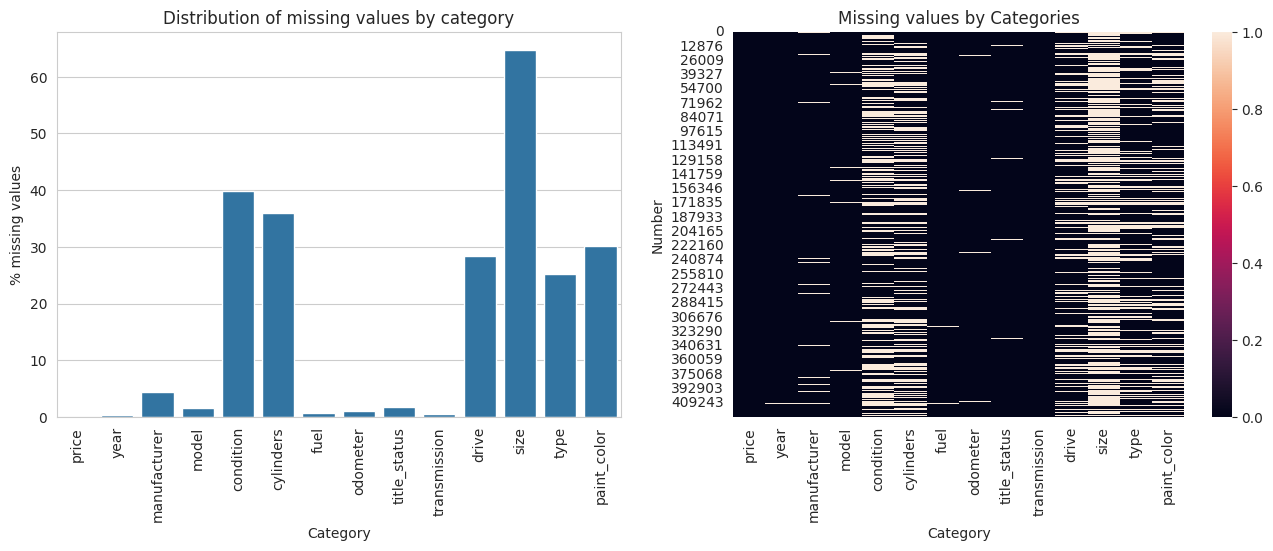

In [8]:
#Check missing values for each category and their distribution
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(data=df.isna().mean().multiply(100).round(2), ax=axes[0])
axes[0].set_title('Distribution of missing values by category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('% missing values')
axes[0].tick_params(axis='x', rotation=90)

sns.heatmap(data=df.isna(), ax=axes[1])
axes[1].set_title('Missing values by Categories')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Number');

In [9]:
#Sort categories by missing values to remove categories with more than 60% missing values. This information is missing and cannot be generated 
print("="*50 + "\n")
print(df.isna().mean().multiply(100).sort_values(ascending=False).round(2))
cat_to_remove = df.isna().mean().multiply(100).sort_values(ascending=False) > 60
cat_to_explore = (df.isna().mean().multiply(100).sort_values(ascending=False) < 60) & (df.isna().mean().multiply(100).sort_values(ascending=False) > 25)
cat_to_fix = df.isna().mean().multiply(100).sort_values(ascending=False) < 5
columns_to_drop = cat_to_remove[cat_to_remove].index.tolist()
columns_to_explore = cat_to_explore[cat_to_explore].index.tolist()
columns_to_fix = cat_to_fix[cat_to_fix].index.tolist()
print("="*50)
print("Category to consider for removal:", columns_to_drop)
print("Category to consider for inputation:", columns_to_explore)
print("Category to fix by droping nulls:", columns_to_fix)
print("="*50)


size            64.70
condition       39.86
cylinders       36.01
paint_color     30.10
drive           28.45
type            25.22
manufacturer     4.37
title_status     1.69
model            1.49
odometer         1.02
fuel             0.69
transmission     0.55
year             0.28
price            0.00
dtype: float64
Category to consider for removal: ['size']
Category to consider for inputation: ['condition', 'cylinders', 'paint_color', 'drive', 'type']
Category to fix by droping nulls: ['manufacturer', 'title_status', 'model', 'odometer', 'fuel', 'transmission', 'year', 'price']


In [10]:
# Performing initial cleanup (removing the rows with less than 5% missing values, dropping "size category" and converting some numerical categories into integers)
dfcr = df.dropna(subset=['title_status', 'odometer', 'fuel', 'transmission', 'year', 'price'])
dfc = dfcr.drop(['size'], axis=1)
dfc['year'] = dfc['year'].astype('Int64')
dfc['odometer'] = dfc['odometer'].astype('Int64')
dfc['price'] = dfc['price'].astype('Int64')

print("="*50)
print("Initial dataframe shape:", df.shape)
print("Cleaned dataframe shape:", dfc.shape)
print("="*50)

Initial dataframe shape: (248303, 14)
Cleaned dataframe shape: (239464, 13)


Q1 (25th percentile): 52,477.00
Q3 (75th percentile): 146,000.00
IQR: 93,523.00
Lower Bound (IQR): -87,807.50
Upper Bound (IQR): 286,284.50
Original number of rows: 239464
Number of rows after IQR outlier removal: 229743
Number of outliers removed by IQR: 18560

Cleaned DataFrame (IQR method) describe():
count     229743.0
mean     104446.87
std       59717.73
min         2000.0
25%        56576.5
50%       100450.0
75%       145411.0
max       286278.0
Name: odometer, dtype: Float64


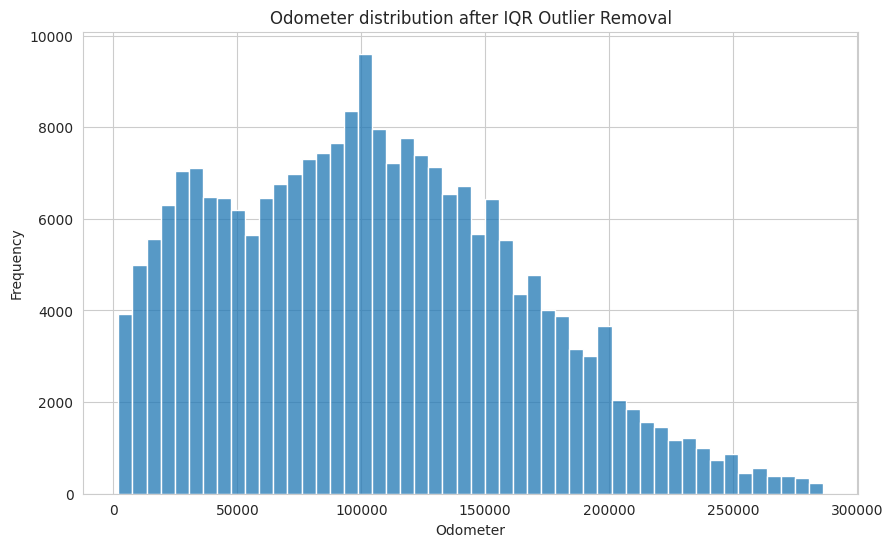

In [11]:
# Remove outliers from numerical features (Odometer) using IQR method.
# Calculate Q1, Q3, and IQR for the 'odometer' column

Q1 = dfc['odometer'].quantile(0.25)
Q3 = dfc['odometer'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

print("=" * 50)
print(f"Q1 (25th percentile): {Q1:,.2f}")
print(f"Q3 (75th percentile): {Q3:,.2f}")
print(f"IQR: {IQR:,.2f}")
print(f"Lower Bound (IQR): {lower_bound_iqr:,.2f}")
print(f"Upper Bound (IQR): {upper_bound_iqr:,.2f}")
print("=" * 50)

# Filter the DataFrame to keep only non-outliers
# We also ensure prices are not negative, as price should naturally be >= 0
dfc_iqr = dfc[(dfc['odometer'] >= 2000) & (dfc['odometer'] >= lower_bound_iqr) & (dfc['odometer'] <= upper_bound_iqr)].copy() # Removinf prices that most probably are outliers since they refer most probably to scrappped cars ot spare parts

print(f"Original number of rows: {len(dfc)}")
print(f"Number of rows after IQR outlier removal: {len(dfc_iqr)}")
print(f"Number of outliers removed by IQR: {len(df) - len(dfc_iqr)}")
print("\nCleaned DataFrame (IQR method) describe():")
print(dfc_iqr['odometer'].describe().round(2))
print("=" * 50)

dfc = dfc_iqr

# Visualize the distribution after IQR outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(dfc_iqr['odometer'], bins=50)
plt.title('Odometer distribution after IQR Outlier Removal')
plt.xlabel('Odometer')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Q1 (25th percentile): 4,995.00
Q3 (75th percentile): 19,900.00
IQR: 14,905.00
Lower Bound (IQR): -17,362.50
Upper Bound (IQR): 42,257.50
Original number of rows: 229743
Number of rows after IQR outlier removal: 192957
Number of outliers removed by IQR: 55346

Cleaned DataFrame (IQR method) describe():
count    192957.0
mean     14086.12
std       9630.07
min        2000.0
25%        6495.0
50%       11299.0
75%       19590.0
max       42250.0
Name: price, dtype: Float64


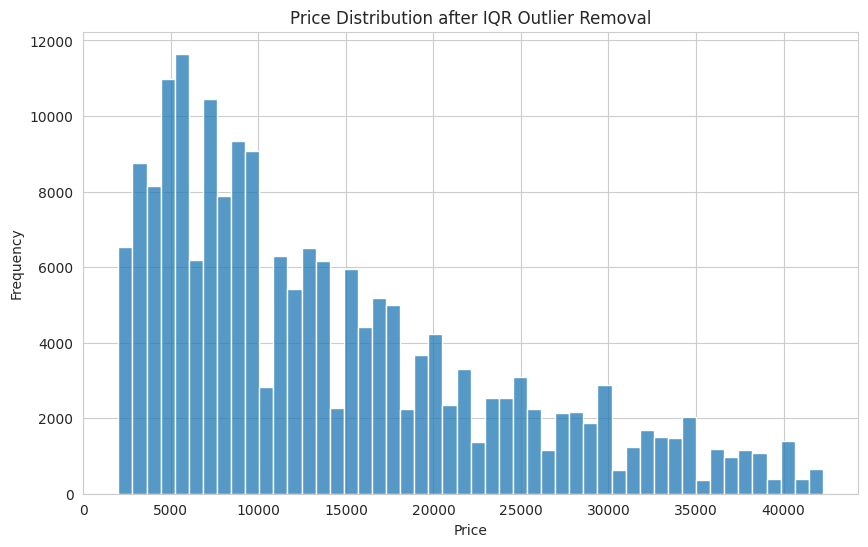

In [12]:
# Remove outliers from numerical features (Price) using IQR method
# Calculate Q1, Q3, and IQR for the 'price' column

Q1 = dfc['price'].quantile(0.25)
Q3 = dfc['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

print("=" * 50)
print(f"Q1 (25th percentile): {Q1:,.2f}")
print(f"Q3 (75th percentile): {Q3:,.2f}")
print(f"IQR: {IQR:,.2f}")
print(f"Lower Bound (IQR): {lower_bound_iqr:,.2f}")
print(f"Upper Bound (IQR): {upper_bound_iqr:,.2f}")
print("="*50)

# Filter the DataFrame to keep only non-outliers
# We also ensure prices are not negative, as price should naturally be >= 0
dfc_iqr = dfc[(dfc['price'] >= 2000) & (dfc['price'] >= lower_bound_iqr) & (dfc['price'] <= upper_bound_iqr)].copy() # removed all prices below 2000 USD since most probably are outliers 

print(f"Original number of rows: {len(dfc)}")
print(f"Number of rows after IQR outlier removal: {len(dfc_iqr)}")
print(f"Number of outliers removed by IQR: {len(df) - len(dfc_iqr)}")
print("\nCleaned DataFrame (IQR method) describe():")
print(dfc_iqr['price'].describe().round(2))
print("=" * 50)

dfc = dfc_iqr.copy()

# Visualize the distribution after IQR outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(dfc['price'], bins=50)
plt.title('Price Distribution after IQR Outlier Removal')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show();

Original number of rows: 192957
Number of rows after outlier removal: 192957
Number of outliers removed: 55346

Cleaned DataFrame describe():
count    192957.0
mean       2009.2
std          9.97
min        1900.0
25%        2006.0
50%        2011.0
75%        2015.0
max        2022.0
Name: year, dtype: Float64


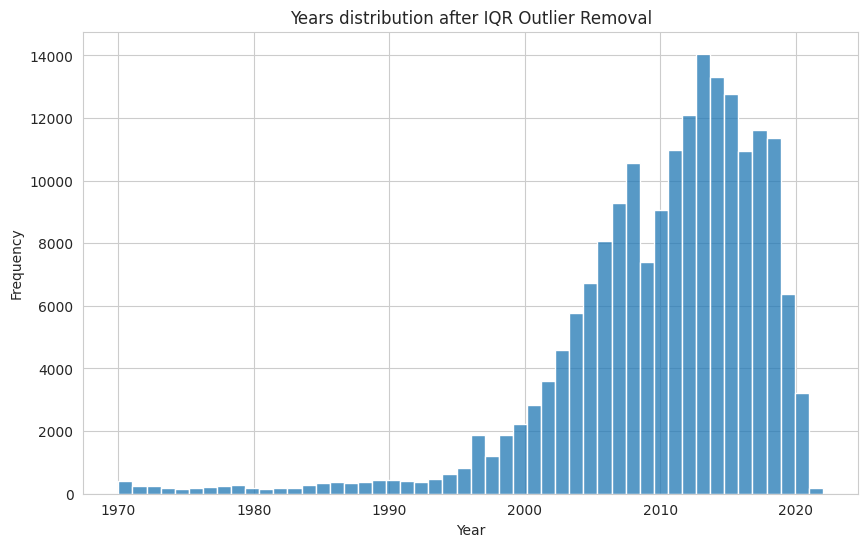

In [13]:
# Remove outliers from numerical features (Year) using IQR method

# Filter the DataFrame to keep only non-outliers
dfco = dfc[(dfc['year'] >= 1970)] # removed all cars older than 1970 since most probably are outliers and cannot be used

print("=" * 50)
print(f"Original number of rows: {len(dfc)}")
print(f"Number of rows after outlier removal: {len(dfc_iqr)}")
print(f"Number of outliers removed: {len(df) - len(dfc_iqr)}")
print("=" * 50)
print("\nCleaned DataFrame describe():")
print(dfc_iqr['year'].describe().round(2))
print("=" * 50)

dfc = dfco.copy()

# Visualize the distribution after IQR outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(dfc['year'], bins=50)
plt.title('Years distribution after IQR Outlier Removal')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show();

In [14]:
# Analyzing categorical feautures
dfc.describe(include = "object")

,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color
count,184029,187916,121329,126327,190081,190081,190081,139302,143428,139770
unique,41,21098,6,8,5,6,3,3,13,12
top,ford,f-150,excellent,4 cylinders,gas,clean,automatic,4wd,sedan,white
freq,29851,3449,57726,47253,172178,180853,167049,57325,41921,33339


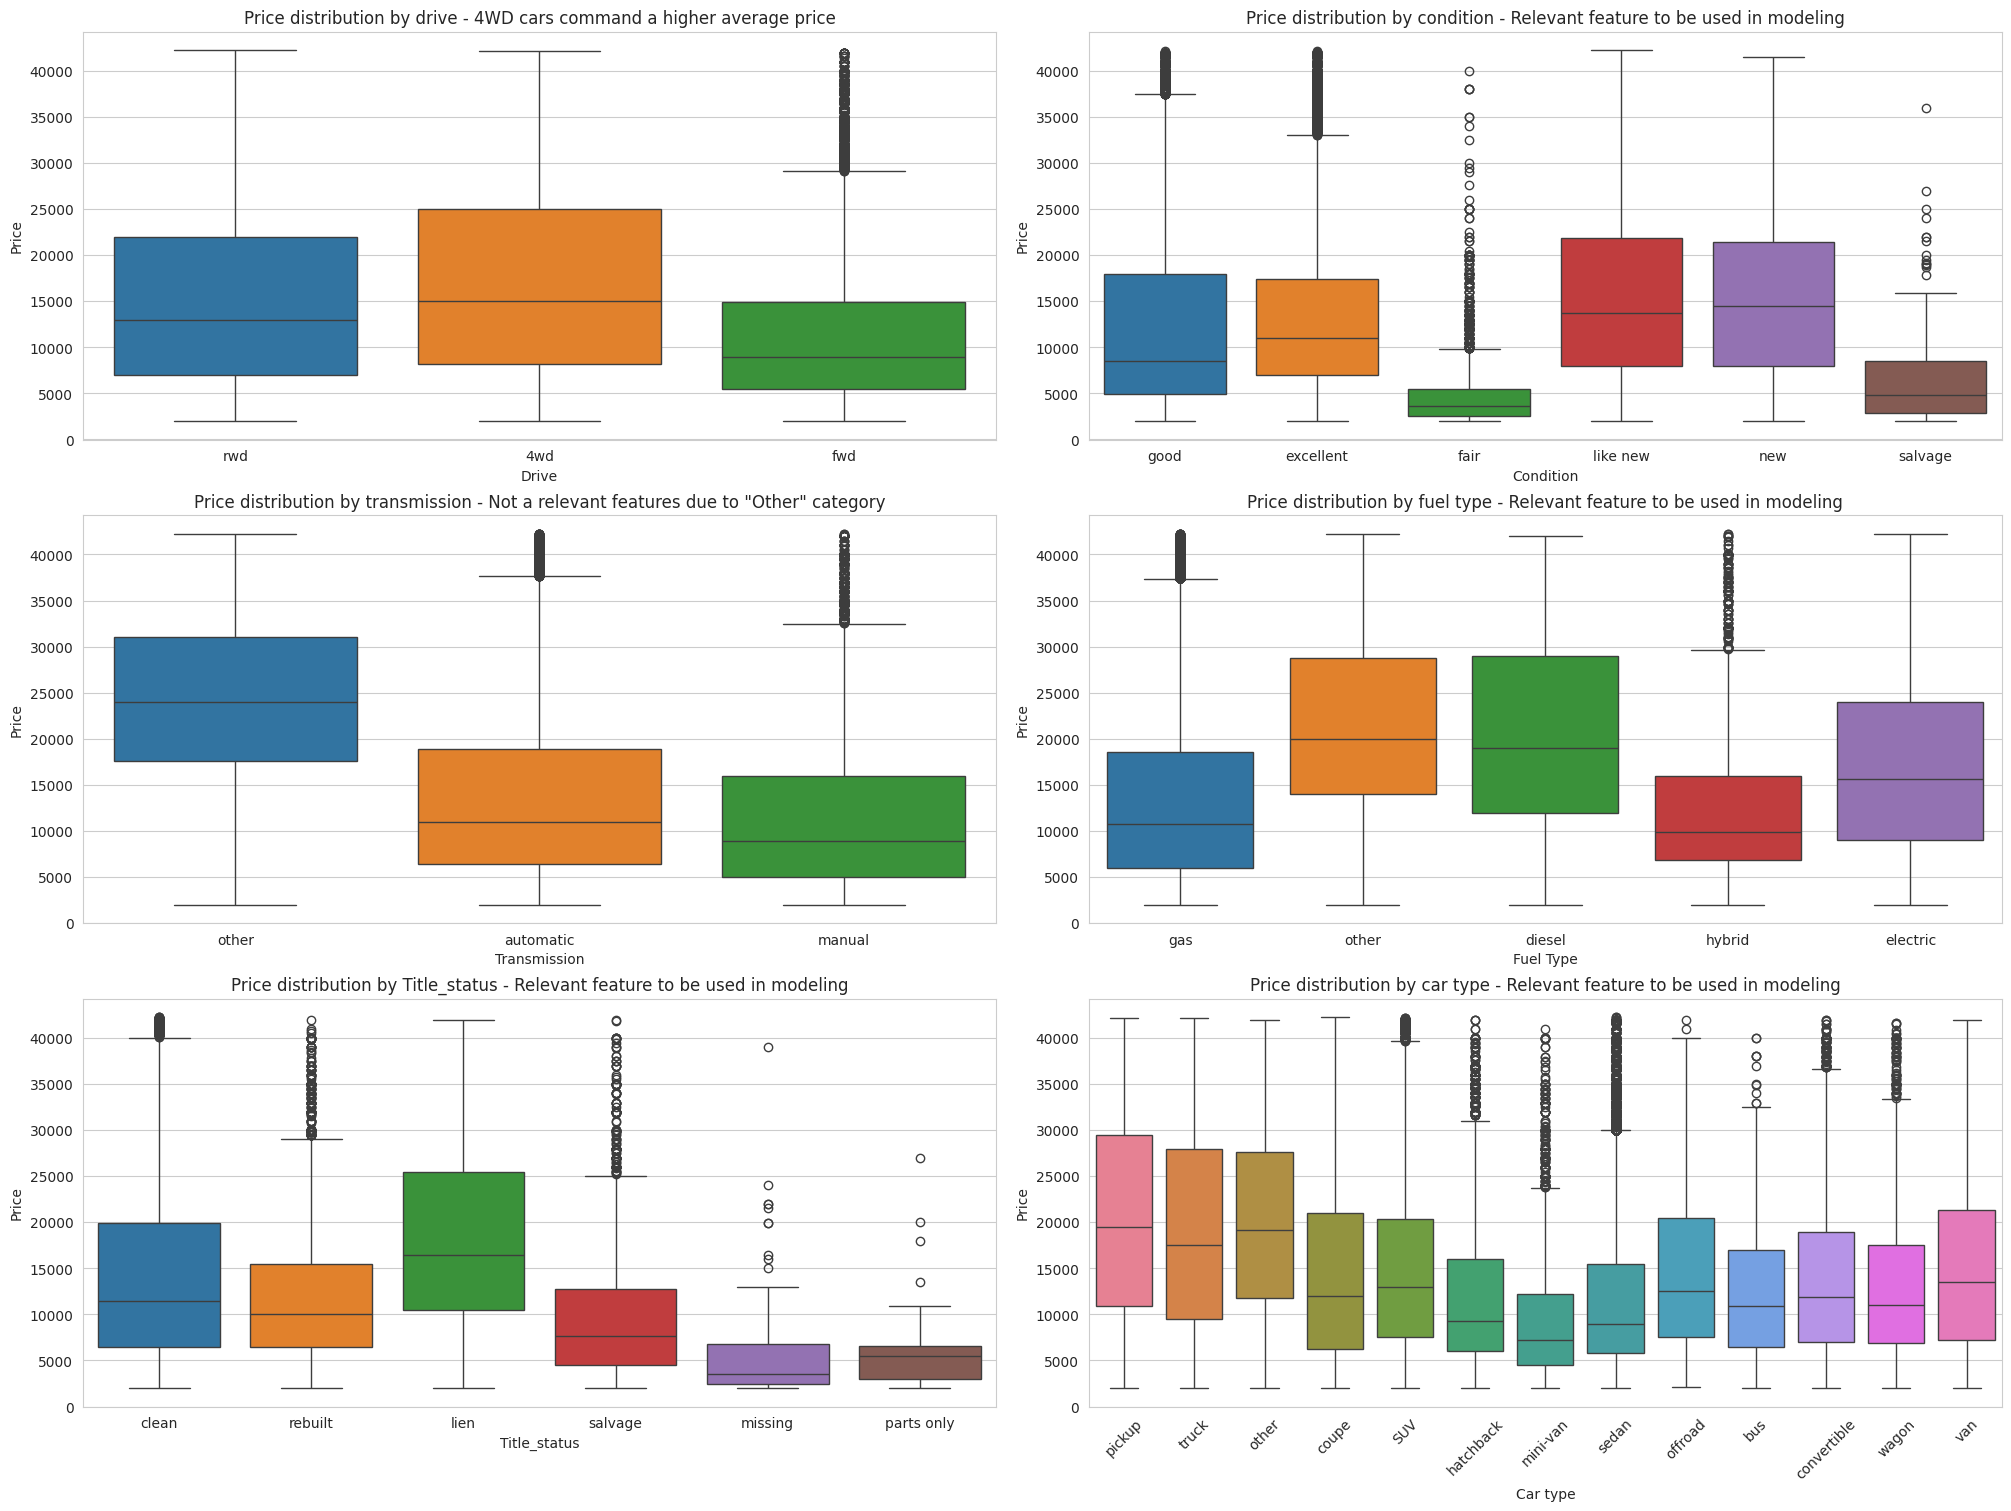

In [15]:
# exploring distribution of prices based on categorical features. Particularly the following feautures that have missing values 
# ['cylinders', 'condition', 'drive', 'paint_color']

fig, axes = plt.subplots(3, 2, figsize=(20, 15), constrained_layout=True)
# Then remove the legend from that specific subplot

sns.boxplot(x="drive", y="price", data=dfc, hue='drive', ax=axes[0,0], legend=False)
axes[0,0].set_title('Price distribution by drive - 4WD cars command a higher average price')
axes[0,0].set_xlabel('Drive')
axes[0,0].set_ylabel('Price')

sns.boxplot(x="condition", y="price", data=dfc, hue='condition', ax=axes[0,1], legend=False)
axes[0,1].set_title('Price distribution by condition - Relevant feature to be used in modeling')
axes[0,1].set_xlabel('Condition')
axes[0,1].set_ylabel('Price');

sns.boxplot(x="transmission", y="price", data=dfc, hue='transmission', ax=axes[1,0], legend=False)
axes[1,0].set_title('Price distribution by transmission - Not a relevant features due to "Other" category')
axes[1,0].set_xlabel('Transmission')
axes[1,0].set_ylabel('Price');

sns.boxplot(x="fuel", y="price", data=dfc, hue='fuel', ax=axes[1,1], legend=False)
axes[1,1].set_title('Price distribution by fuel type - Relevant feature to be used in modeling')
axes[1,1].set_xlabel('Fuel Type')
axes[1,1].set_ylabel('Price')

sns.boxplot(x="title_status", y="price", data=dfc, hue='title_status', ax=axes[2,0], legend=False)
axes[2,0].set_title('Price distribution by Title_status - Relevant feature to be used in modeling')
axes[2,0].set_xlabel('Title_status')
axes[2,0].set_ylabel('Price')

sns.boxplot(x="type", y="price", data=dfc, hue='type', ax=axes[2,1], legend=False)
axes[2,1].set_title('Price distribution by car type - Relevant feature to be used in modeling')
axes[2,1].set_xlabel('Car type')
axes[2,1].set_ylabel('Price')
axes[2,1].tick_params(axis='x', rotation=45)

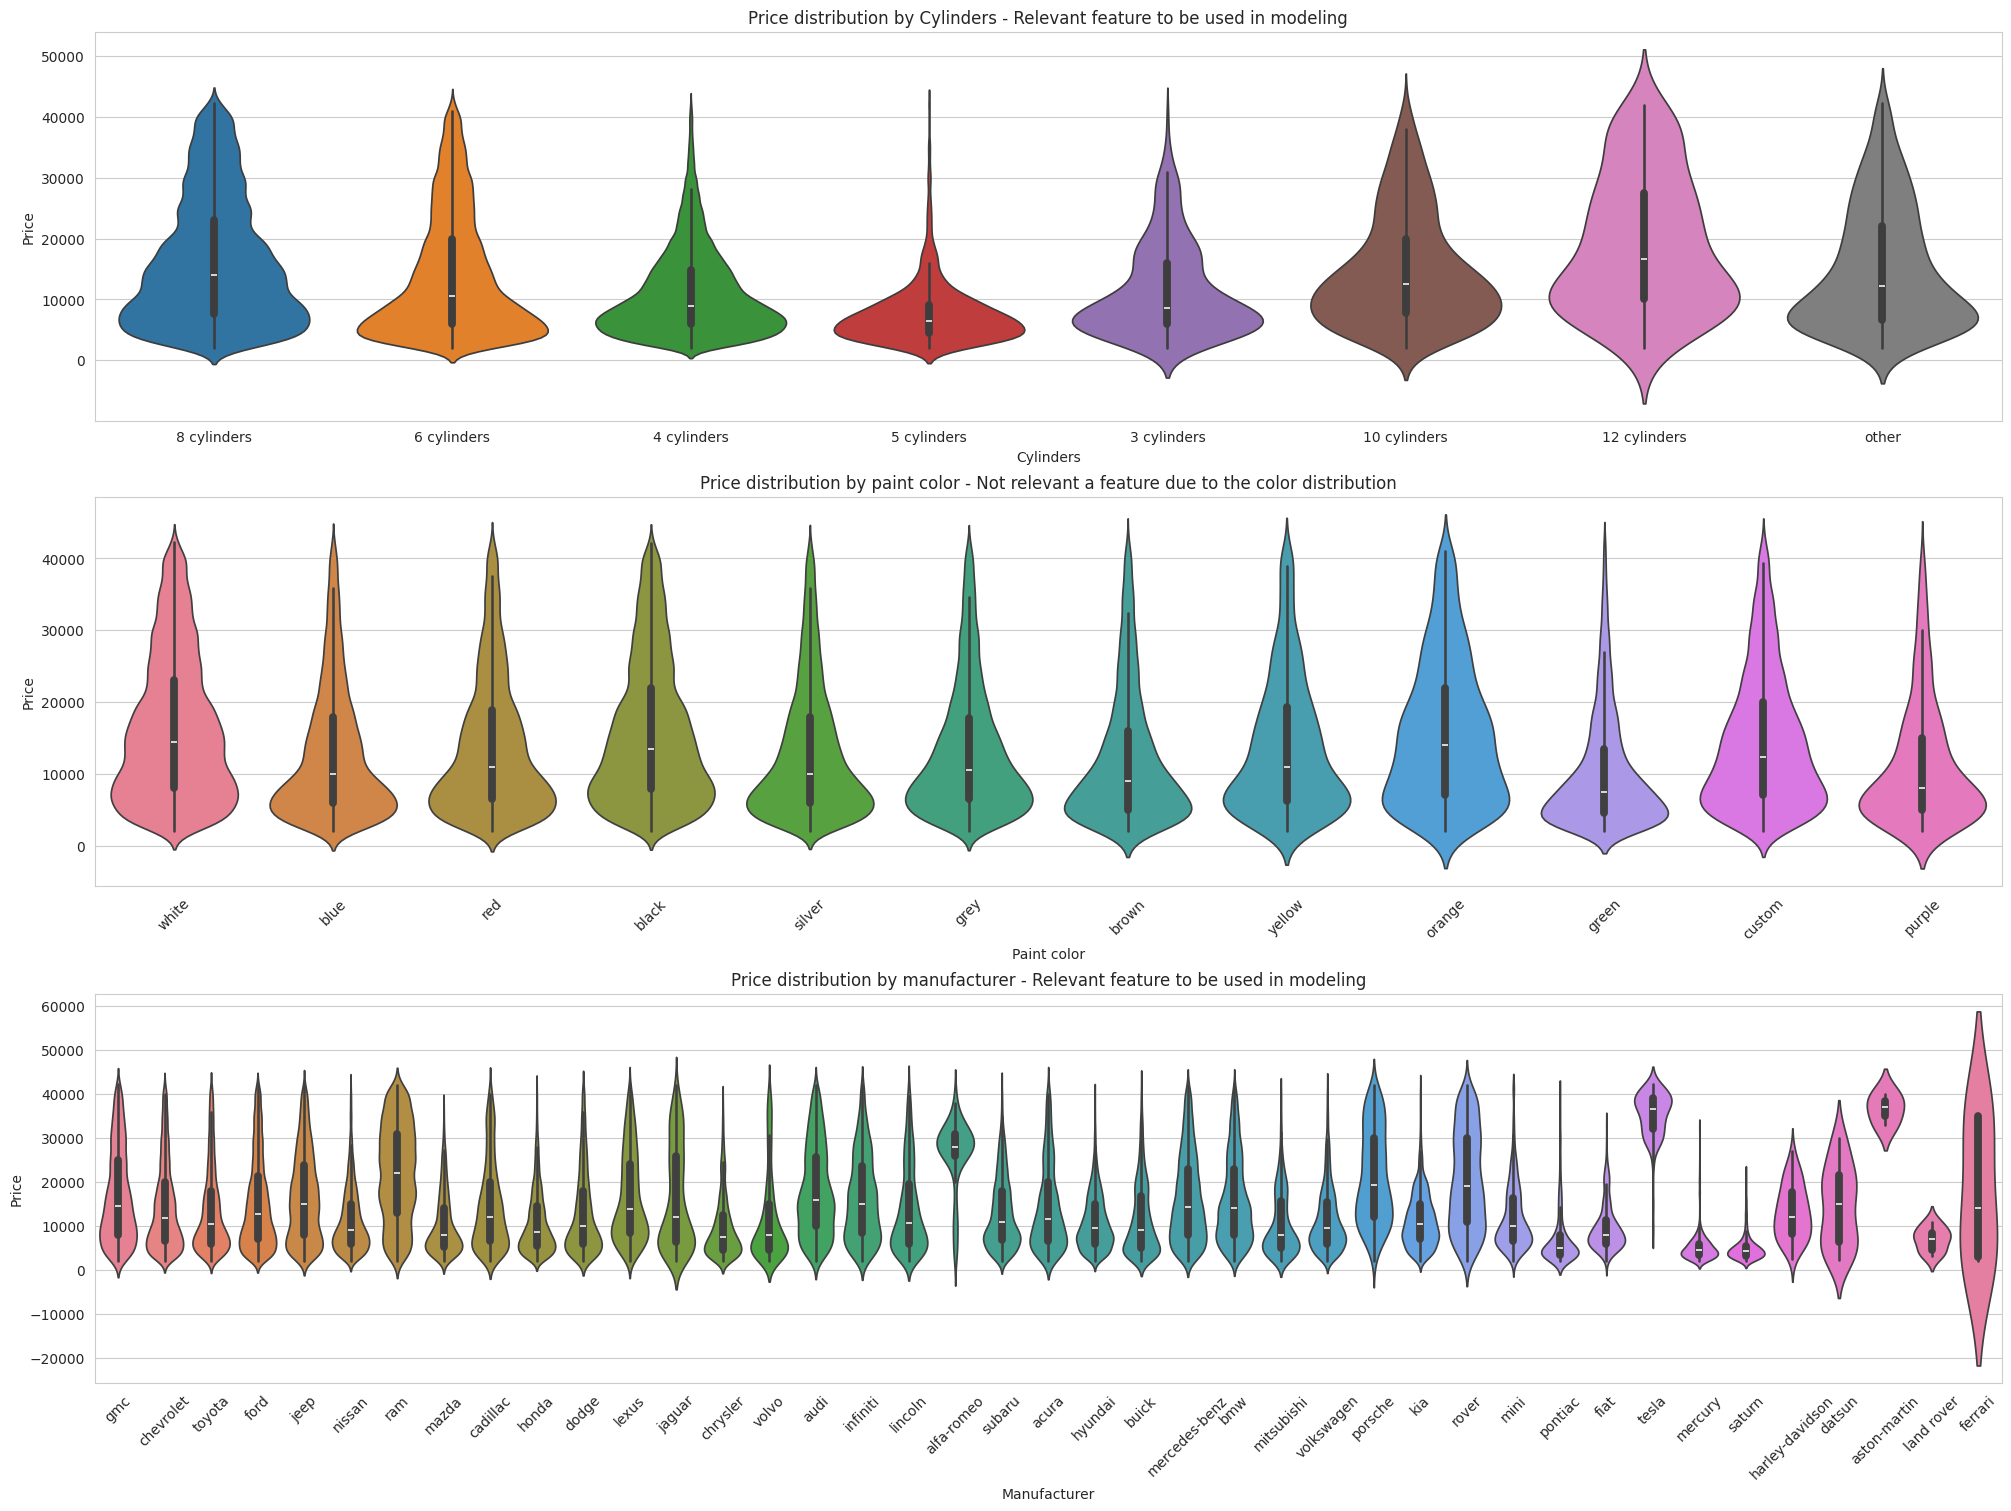

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15), constrained_layout=True)

sns.violinplot(x="cylinders", y="price", hue='cylinders', data=dfc, ax=axes[0], legend=False)
axes[0].set_title('Price distribution by Cylinders - Relevant feature to be used in modeling')
axes[0].set_xlabel('Cylinders')
axes[0].set_ylabel('Price')

sns.violinplot(x="paint_color", y="price", data=dfc, hue='paint_color', ax=axes[1], legend=False)
axes[1].set_title('Price distribution by paint color - Not relevant a feature due to the color distribution')
axes[1].set_xlabel('Paint color')
axes[1].set_ylabel('Price')
axes[1].tick_params(axis='x', rotation=45)

sns.violinplot(x="manufacturer", y="price", data=dfc, hue='manufacturer', ax=axes[2], legend=False)
axes[2].set_title('Price distribution by manufacturer - Relevant feature to be used in modeling')
axes[2].set_xlabel('Manufacturer')
axes[2].set_ylabel('Price')
axes[2].tick_params(axis='x', rotation=45)

In [17]:
# Remove Title status "missing" and "parts only" since they are creating data distorsion
# Define the statuses you want to remove
statuses_to_remove = ['missing', 'parts only']

# Create a boolean mask:
mask_to_keep = ~dfc['title_status'].isin(statuses_to_remove)

# Filter the DataFrame using the mask
dfc = dfc[mask_to_keep].copy()



Significat correlations identifies betwwen price, year and odometer




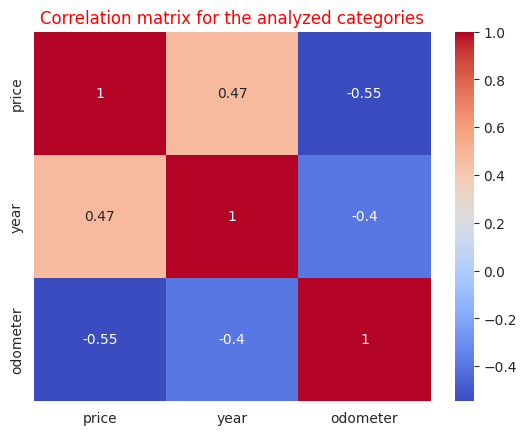

In [18]:
#Numerical features correlation analysis using heatmap
sns.heatmap(dfc.corr(numeric_only=True), annot=True, cmap='coolwarm');
plt.title("Correlation matrix for the analyzed categories", color = 'Red')

print("\n" + "="*70 + "\n")
print("Significat correlations identifies betwwen price, year and odometer")
print("\n" + "="*70 + "\n")



For some categorical features we have nulls that have to be addressed




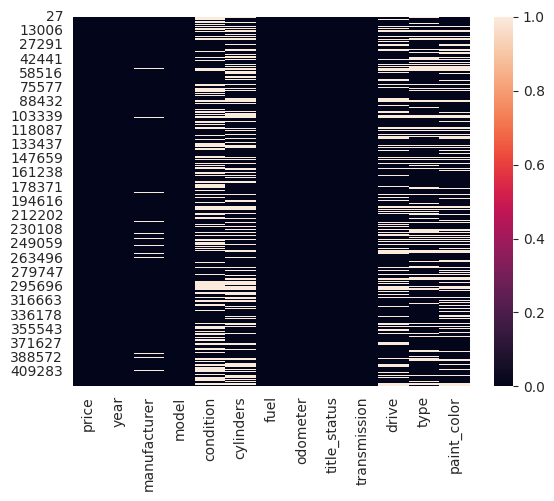

In [19]:
#Checking distribution of nulls for categorical features
sns.heatmap(data=dfc.isna());
print("\n" + "="*70 + "\n")
print("For some categorical features we have nulls that have to be addressed")
print("\n" + "="*70 + "\n")

In [20]:
# Explore the categorical features to identify the most appropriate inputation method
cat_columns = ["cylinders", "condition", "drive", "type", "paint_color"]
print("=" * 50)
for i in cat_columns:
    display(dfc.groupby(i)["price"].agg(["mean", "median", "count"]).round(2))
    print("=" * 50)

,mean,median,count
cylinders,,,
10 cylinders,14732.08,12500.0,535
12 cylinders,18926.15,15500.0,85
3 cylinders,11503.51,8800.0,315
4 cylinders,11030.44,8995.0,47208
5 cylinders,7685.44,6500.0,1192
6 cylinders,13842.25,10500.0,45420
8 cylinders,16225.83,13994.0,30913
other,15087.61,12497.5,488


,mean,median,count
condition,,,
excellent,13282.02,10988.0,57699
fair,4848.38,3600.0,3611
good,12457.73,8500.0,46287
like new,15860.7,13700.0,12890
new,16067.45,14500.0,429
salvage,6566.02,4750.0,232


,mean,median,count
drive,,,
4wd,17219.16,14995.0,57263
fwd,10891.92,8990.0,55633
rwd,15344.75,12995.0,26243


,mean,median,count
type,,,
SUV,14974.3,12995.0,38553
bus,13141.53,10947.5,286
convertible,13897.18,11950.0,3969
coupe,14678.51,12000.0,7342
hatchback,11672.69,9250.0,7217
mini-van,9490.88,7200.0,3087
offroad,15070.94,12500.0,437
other,20006.29,19279.0,5347
pickup,20303.44,19553.0,13108


,mean,median,count
paint_color,,,
black,15737.66,13500.0,27499
blue,12864.03,9980.0,15196
brown,12121.92,8995.0,3451
custom,14463.96,12330.0,3861
green,10233.21,7500.0,3921
grey,13202.86,10500.0,14626
orange,15647.89,13992.5,858
purple,11233.29,7995.0,379
red,13718.63,10990.0,13807


In [21]:
# I will use random distribution using weights to fill in the missing values.
df_imputed = dfc.copy()
categorical_columns_to_impute = ["cylinders", "condition", "drive", "type", "paint_color", 'model', 'manufacturer']

for col in categorical_columns_to_impute:
    # Get the indices of rows where the current column is null
    null_indices = df_imputed[df_imputed[col].isnull()].index
    num_nulls = len(null_indices)

    if num_nulls > 0:
        # Get all non-null unique values and their frequencies for the current column
        non_null_counts = df_imputed[col].value_counts()

        categories_to_choose_from = non_null_counts.index.tolist()
        probabilities = (non_null_counts / non_null_counts.sum()).tolist()

        # Generate random choices based on frequencies
        random_fills = np.random.choice(
            categories_to_choose_from,
            size=num_nulls,
            replace=True, # Allow choosing same category multiple times
            p=probabilities # Apply the calculated probabilities
        )

        # Fill the nulls in the DataFrame for the current column
        df_imputed.loc[null_indices, col] = random_fills
        print(f"Filled {num_nulls} nulls in column '{col}' using random sampling.")

print("="*40)
print("--- Null counts after imputation: ---")
print(df_imputed.isnull().sum())
print("="*40)
dfc = df_imputed.copy()

Filled 63695 nulls in column 'cylinders' using random sampling.
Filled 68703 nulls in column 'condition' using random sampling.
Filled 50712 nulls in column 'drive' using random sampling.
Filled 46577 nulls in column 'type' using random sampling.
Filled 50242 nulls in column 'paint_color' using random sampling.
Filled 2151 nulls in column 'model' using random sampling.
Filled 6022 nulls in column 'manufacturer' using random sampling.
--- Null counts after imputation: ---
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
dtype: int64


### 4. Modeling and experimentation

#### EXPERIMENT A - Checking different models results when using ONLY Numerical features

In [22]:
# ========================================================================
#   1. CREATE THE PREPROCESSING PIPELINE
# ========================================================================

# Create a new DataFrame with only the target and numerical features
numerical_cols = ['year', 'odometer']
df_numerical = dfc[['price'] + numerical_cols].copy()

# Separate features (X) and target (y) from this new DataFrame
X_num = df_numerical.drop('price', axis=1)
y_num = df_numerical['price']

# Split data into training and testing sets
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.2, random_state=42)

print(f"Created training set with {len(X_train_num)} rows.")

numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

X_train_processed_num = numeric_pipeline.fit_transform(X_train_num)
X_test_processed_num = numeric_pipeline.transform(X_test_num)

# ========================================================================
#   2. DEFINE MODELS AND PREPARE FOR TUNING
# ========================================================================
def display_feature_importance(model, feature_names, model_name):
    """
    Displays the most relevant features for a fitted linear model.
    """
    print(f"\n--- Feature Importance for {model_name} ---")

    # Check if the model is a Pipeline
    if isinstance(model, Pipeline):
        final_estimator = model.named_steps['regressor']
        coefficients = final_estimator.coef_

        # Get the feature creation step to generate the correct feature names
        poly_features_step = model.named_steps['poly_features']
        final_feature_names = poly_features_step.get_feature_names_out(feature_names)
        
        coefs = pd.Series(coefficients, index=final_feature_names)
    else:
        coefs = pd.Series(model.coef_, index=feature_names)
    
    important_coefs_abs = coefs.abs().sort_values(ascending=False)
    print(important_coefs_abs)
    print("-" * 40)

# Define the Polynomial Regression Pipeline as a base model
polynomial_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(include_bias=False)),
    ("regressor", LinearRegression())
])

models_to_tune = {
    "Linear Regression": {"model": LinearRegression(fit_intercept=False), "params": {}},
    "Ridge Regression": {"model": Ridge(random_state=42), "params": {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}},
    "Lasso Regression": {"model": Lasso(max_iter=10000, random_state=42), "params": {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}},
    "Polynomial Regression": {"model": polynomial_pipeline, "params": {'poly_features__degree': [2, 3] }}
}

results_num = {}

# ========================================================================
#   3. RUN THE TUNING LOOP
# ========================================================================
for name, config in tqdm(models_to_tune.items(), desc="Tuning Numerical Models"):
    
    grid_search = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    if name == "Polynomial Regression":
        grid_search.fit(X_train_num, y_train_num)
        # We need to transform the test data using the fitted pipeline for prediction
        y_pred_num = grid_search.best_estimator_.predict(X_test_num)
    else:
        # Fit on the numerically processed training data
        grid_search.fit(X_train_processed_num, y_train_num)
        # Predict on the numerically processed test data
        y_pred_num = grid_search.best_estimator_.predict(X_test_processed_num)

    model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    results_num[name] = {
        "Best Params": best_params,
        "R2": r2_score(y_test_num, y_pred_num),
        "RMSE": np.sqrt(mean_squared_error(y_test_num, y_pred_num)),
        "model_object": model
    }

# ========================================================================
#   4. DISPLAY THE FINAL RESULTS
# ========================================================================
print("="*60)
print(" EXPERIMENT A (Numerical Features ONLY) : FINAL RESULTS       ")
print("="*60)

# --- Part A: Display the Feature Importance for each model ---
print("\n--- DETAILED FEATURE IMPORTANCE ---")

for name, result in results_num.items():
    display_feature_importance(result["model_object"], numerical_cols, name)

# --- Part B: Display the Summary Performance Table ---
results_for_df = {name: {k: v for k, v in result.items() if k != 'model_object'} for name, result in results_num.items()}
results_num_df = pd.DataFrame(results_for_df).T

print("\n--- SUMMARY OF TUNED MODEL PERFORMANCE (Numerical Features ONLY) ---")
print(results_num_df.sort_values(by="RMSE"))

Created training set with 151880 rows.


Tuning Numerical Models: 100%|████████████████████| 4/4 [00:04<00:00,  1.15s/it]

 EXPERIMENT A (Numerical Features ONLY) : FINAL RESULTS       

--- DETAILED FEATURE IMPORTANCE ---

--- Feature Importance for Linear Regression ---
odometer    4106.423076
year        2888.951327
dtype: float64
----------------------------------------

--- Feature Importance for Ridge Regression ---
odometer    4106.191765
year        2888.852668
dtype: float64
----------------------------------------

--- Feature Importance for Lasso Regression ---
odometer    4106.341930
year        2888.903689
dtype: float64
----------------------------------------

--- Feature Importance for Polynomial Regression ---
year               6287.784118
year^2             2881.880636
odometer           2779.039528
odometer^2         1106.894441
year odometer       830.041077
year^3              319.956257
year^2 odometer     301.293786
year odometer^2      35.576897
odometer^3            3.819875
dtype: float64
----------------------------------------

--- SUMMARY OF TUNED MODEL PERFORMANCE (Numerical 

#### EXPERIMENT B - Checking models performance when adding categorical features + PCA

In [23]:
# We will not use Lasso model in this experiment because by default Lasso selects principal components. Lasso regression is covered in Experiment C
# ========================================================================
#   1. DEFINE THE PREPROCESSOR
# ========================================================================

print("--- Starting Data Preparation ---")

# Separate features (X) and target (y)
X = dfc.drop('price', axis=1)
y = dfc['price']

# Automatically identify feature types from the DataFrame
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
nominal_features = ['manufacturer', 'condition', 'fuel', 'title_status', 'type', 'drive']

print(f"Identified {len(numerical_features)} numerical features: {numerical_features}")
print(f"Identified {len(nominal_features)} nominal features: {nominal_features}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=100), nominal_features)
    ],
    remainder='drop'
)

# ========================================================================
#   2. EXPERIMENT B: SETUP AND EXECUTION
# ========================================================================
print("="*80)
print("EXPERIMENT B: Finding the best model WITH PCA integrated in a pipeline")
print("="*80)

# Define the models and their corresponding parameter grids in a list of dictionaries
experiment_configs = [
    {
        "name": "Ridge Regression",
        "pipeline": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('pca', PCA()),
            ('regressor', Ridge(random_state=42))
        ]),
        "params": {
            'pca__n_components': [10, 20, 40, 60, 80, 100],
            'regressor__alpha': [0.1, 1.0, 10.0, 50.0, 100.0]
        }
    },
    {
        "name": "Linear Regression",
        "pipeline": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('pca', PCA()),
            ('regressor', LinearRegression(fit_intercept=False))
        ]),
        "params": {
            'pca__n_components': [10, 20, 40, 60, 80, 100]
        }
    },
    {
        "name": "Polynomial Regression",
        "pipeline": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('pca', PCA()),
            ('poly_features', PolynomialFeatures(include_bias=False)),
            ('regressor', LinearRegression())
        ]),
        "params": {
            'pca__n_components': [10, 20, 40, 60],
            'poly_features__degree': [2] # I run only for degree 2 because degree 3 will take long time
        }
    }
]

results_pca = {}

# Loop through each configuration to run the experiment
for config in experiment_configs:
    model_name = config["name"]
    pipeline = config["pipeline"]
    param_grid = config["params"]

    print(f"\n--- Tuning {model_name} with PCA ---")

    # Set up and run GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Get the best model and make predictions
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)

    # Store the results
    results_pca[model_name] = {
        "Best Params": str(grid_search.best_params_),
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "pipeline_object": best_pipeline
    }
    
    print(f"\nBest parameters found for {model_name}+PCA: {grid_search.best_params_}")


# ========================================================================
#   3. DISPLAY FINAL SUMMARY FOR EXPERIMENT B
# ========================================================================
print("\n"+"="*80)
print("Summary of Tuned Model Performance (WITH PCA):")
results_pca_df = pd.DataFrame(results_pca).T

# Select the most important columns for the summary
summary_view = results_pca_df[['Best Params', 'R2', 'RMSE']]
display(summary_view.sort_values(by="RMSE"))
print("="*80)

--- Starting Data Preparation ---
Identified 2 numerical features: ['year', 'odometer']
Identified 6 nominal features: ['manufacturer', 'condition', 'fuel', 'title_status', 'type', 'drive']
Data split into training (151880 rows) and testing (37971 rows) sets.
EXPERIMENT B: Finding the best model WITH PCA integrated in a pipeline

--- Tuning Ridge Regression with PCA ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters found for Ridge Regression+PCA: {'pca__n_components': 60, 'regressor__alpha': 1.0}

--- Tuning Linear Regression with PCA ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters found for Linear Regression+PCA: {'pca__n_components': 60}

--- Tuning Polynomial Regression with PCA ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters found for Polynomial Regression+PCA: {'pca__n_components': 40, 'poly_features__degree': 2}

Summary of Tuned Model Performance (WITH PCA):


,Best Params,R2,RMSE
Polynomial Regression,"{'pca__n_components': 40, 'poly_features__degr...",0.724384,5080.942233
Ridge Regression,"{'pca__n_components': 60, 'regressor__alpha': ...",0.597145,6142.805119
Linear Regression,{'pca__n_components': 60},-1.519277,15361.383444


#### EXPERIMENT C - Checking Lasso model performance when adding categorical features without PCA

In [24]:
# ========================================================================
#   1. DATA PREPARATION
# ========================================================================
print("--- Starting Data Preparation ---")

# Separate features (X) and target (y)
X = dfc.drop('price', axis=1)
y = dfc['price']

# --- Define Feature Lists ---
# All numerical features will be scaled, and nominal features will be one-hot encoded.
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
nominal_features = ['manufacturer', 'condition', 'fuel', 'title_status', 'type', 'drive', 'transmission', 'paint_color']

print(f"Features that will be STANDARD-SCALED: {numerical_features}")
print(f"Features that will be ONE-HOT-ENCODED: {nominal_features}")


# --- Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")


# --- Define preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=100), nominal_features)
    ],
    remainder='drop'
)

# ========================================================================
#   2. EXPERIMENT: LASSO REGRESSION
# ========================================================================
print("="*80)
print("EXPERIMENT C: Finding the best LASSO model on original features")
print("="*80)

# Define the pipeline for Lasso Regression
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(random_state=42, max_iter=1000, tol=1e-3))
])

# Define the parameter distribution for alpha.
param_dist = {
    'regressor__alpha': loguniform(1e-4, 1e2)
}

# Set up RandomizedSearchCV for efficient tuning of alpha
random_search = RandomizedSearchCV(
    estimator=lasso_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"\n--- Tuning Lasso Regression (running {random_search.n_iter} iterations) ---")
random_search.fit(X_train, y_train)

# Get the best model and make predictions
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_test)


# --- Store and display the results ---
results = {}
results['Lasso Regression'] = {
    "Best Params": str(random_search.best_params_),
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
}

print(f"\nBest parameters found for Lasso: {random_search.best_params_}")

final_lasso_model = best_pipeline.named_steps['regressor']
num_features_selected = np.sum(final_lasso_model.coef_ != 0)
num_total_features = len(final_lasso_model.coef_)
print(f"Lasso selected {num_features_selected} out of {num_total_features} features.")

# ========================================================================
#   3. DISPLAY FINAL SUMMARY
# ========================================================================
print("="*80)
print("Summary of Tuned Model Performance:")
results_df = pd.DataFrame(results).T

# Select the most important columns for the summary
summary_view = results_df[['Best Params', 'R2', 'RMSE']]
display(summary_view.sort_values(by="RMSE"))
print("="*80)

--- Starting Data Preparation ---
Features that will be STANDARD-SCALED: ['year', 'odometer']
Features that will be ONE-HOT-ENCODED: ['manufacturer', 'condition', 'fuel', 'title_status', 'type', 'drive', 'transmission', 'paint_color']

Data split into training (151880 rows) and testing (37971 rows) sets.
EXPERIMENT C: Finding the best LASSO model on original features

--- Tuning Lasso Regression (running 15 iterations) ---
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameters found for Lasso: {'regressor__alpha': np.float64(0.39079671568228835)}
Lasso selected 79 out of 89 features.
Summary of Tuned Model Performance:


,Best Params,R2,RMSE
Lasso Regression,{'regressor__alpha': np.float64(0.390796715682...,0.608116,6058.581474


### Evaluation

In [25]:
# =======================================================================
#   CONSOLIDATE PERFORMANCE METRICS FROM ALL EXPERIMENTS
# =======================================================================
print("="*61)
print("           AGGREGATED MODEL PERFORMANCE SUMMARY           ")
print("="*61)

performance_data = []

# --- Experiment A: Numerical Features ONLY ---
for model_name, metrics in results_num.items():
    performance_data.append({
        "Experiment": "A (Numerical Only)",
        "Model": model_name,
        "R2": metrics["R2"],
        "RMSE": metrics["RMSE"]
    })

# --- Experiment B: Features with PCA ---
for model_name, metrics in results_pca.items():
    performance_data.append({
        "Experiment": "B (with PCA)",
        "Model": model_name,
        "R2": metrics["R2"],
        "RMSE": metrics["RMSE"]
    })

# --- Experiment C: Lasso on All Features ---
for model_name, metrics in results.items():
    performance_data.append({
        "Experiment": "C (Lasso)",
        "Model": model_name,
        "R2": metrics["R2"],
        "RMSE": metrics["RMSE"]
    })

# Create and display the summary DataFrame, sorted by the best (lowest) RMSE
performance_df = pd.DataFrame(performance_data)

# cleaning up negative R2 values
performance_df.loc[performance_df['R2'] < 0, 'R2'] = 0

# Sort the values and format the 'R2' and 'RMSE' columns for display
display(performance_df.sort_values(by="RMSE", ascending=True)
                      .reset_index(drop=True)
                      .style.format({'R2': '{:.3f}', 'RMSE': '{:.0f}'}))

           AGGREGATED MODEL PERFORMANCE SUMMARY           


,Experiment,Model,R2,RMSE
0,B (with PCA),Polynomial Regression,0.724,5081
1,C (Lasso),Lasso Regression,0.608,6059
2,B (with PCA),Ridge Regression,0.597,6143
3,A (Numerical Only),Polynomial Regression,0.474,7019
4,A (Numerical Only),Lasso Regression,0.379,7629
5,A (Numerical Only),Ridge Regression,0.379,7629
6,B (with PCA),Linear Regression,0.000,15361
7,A (Numerical Only),Linear Regression,0.000,16020


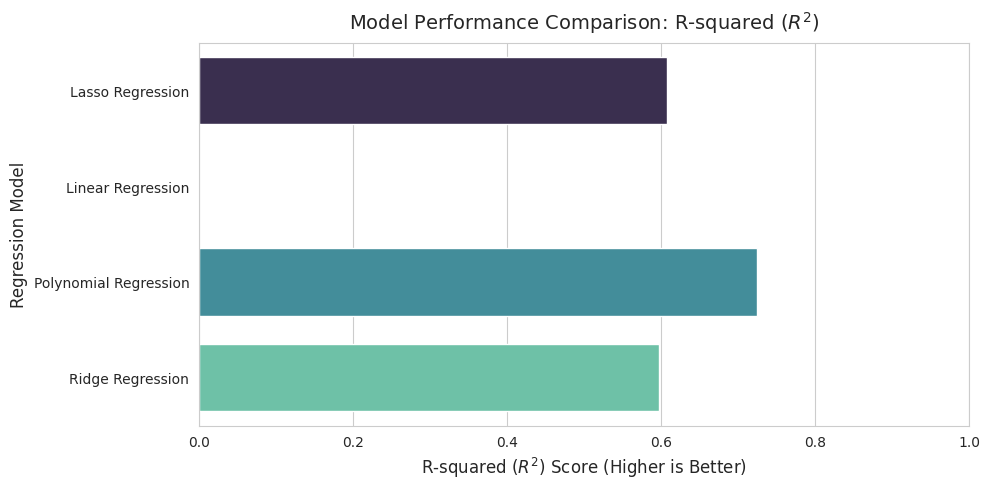

In [26]:
# Display Models performance on a chart
# For each 'Model' group, find the index of the row with the maximum 'R2'
idx_of_best_r2 = performance_df.groupby('Model')['R2'].idxmax()

# Use .loc to select only those rows from the original DataFrame
best_performance_df = performance_df.loc[idx_of_best_r2]

#Plot the new dataframe
plt.figure(figsize=(10, 5))

ax = sns.barplot(
    y='Model',
    x='R2',
    data=best_performance_df,
    palette='mako',
    width=0.7,
    errorbar=None
)

plt.title('Model Performance Comparison: R-squared ($R^2$)', fontsize=14, pad=10)
plt.xlabel('R-squared ($R^2$) Score (Higher is Better)', fontsize=12)
plt.ylabel('Regression Model', fontsize=12)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show();


In [27]:
# ========================================================================
#  FINAL ANALYSIS: Feature Importance for the Best Performing Model
# ========================================================================
from sklearn.inspection import permutation_importance

print("\n" + "="*80)
print("ANALYSIS: Calculating Feature Importance for the Best Model (Polynomial Regression)")
print("="*80)

# --- 1. Retrieve the saved Polynomial Regression pipeline ---
model_to_analyze = 'Polynomial Regression'

if model_to_analyze in results_pca:
    # Retrieve the saved pipeline object
    best_poly_pipeline = results_pca[model_to_analyze]['pipeline_object']

    # --- 2. Calculate Permutation Importance ---
    print("Calculating permutation importance on the test set... (This may take a moment)")
    result = permutation_importance(
        best_poly_pipeline,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    # --- 3. Create a DataFrame with the results ---
    importance_df = pd.DataFrame(
        {'importance_mean': result.importances_mean,
         'importance_std': result.importances_std},
        index=X_test.columns
    ).sort_values('importance_mean', ascending=False)

    # ========================================================================
    #  NEW: Filter out features with zero or negative importance
    # ========================================================================
    significant_features_df = importance_df[importance_df['importance_mean'] > 0]
    
    print("\n--- Final Feature Importance Ranking (Showing Only Features with Positive Importance) ---")
    print("Features are ranked by the average drop in the model's R2 score when shuffled.")
    
    # Display the new, filtered DataFrame
    display(significant_features_df)

else:
    print(f"\nCould not find results for '{model_to_analyze}'.")


ANALYSIS: Calculating Feature Importance for the Best Model (Polynomial Regression)
Calculating permutation importance on the test set... (This may take a moment)

--- Final Feature Importance Ranking (Showing Only Features with Positive Importance) ---
Features are ranked by the average drop in the model's R2 score when shuffled.


,importance_mean,importance_std
year,0.495418,0.003356
odometer,0.251152,0.004029
manufacturer,0.155248,0.001911
fuel,0.100378,0.001861
type,0.085975,0.001753
drive,0.064831,0.000915
title_status,0.017463,0.000647
condition,0.011901,0.000406


In [28]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total Elapsed time : {elapsed_time/60} Minutes")

Total Elapsed time : 11.64403921365738 Minutes


### Deployment

#### TECHNICAL ASSESSMENT AND CONCLUSIONS:
I have evaluated four regression models ( Linear, Ridge, Polynomial and Lasso ) using three experiments that allowed me to evaluate and select the best model for the price prediction and for the key recommendation for the dealer:
- Experiment A - I've run all four models on numerical features - the best model was  Polynomial Regression (3rd degree). On numerical features it seems that the best performance we can get with the current models is close to R2=0.47. Linear Regression was not able to predict anything.
- Experiment B - I've run three models (Linear, Ridge and Polynomial) on numerical and a subset of categorical features(the ones with the most significant variance) using PCA. In this case Polynomial regression (2nd degree + 40 parameters) delivered the best result(R2=0.723). Linear Regression was not able to predict anything. Note: Lasso regression was excluded from this experiment because has its own PCA.
- Experiment C - I've run Lasso regression on all features. The performace was modest R2=0.607 when compared with polynomial regression. Bestmodel with (alpha=0.390 + 79 parameters)

Overall comclusion is that due to the complex data that its multiple features is impossible to obtain a good model with simple linear regression models like Liner, Ridge or Lasso models. The key is to use pipeline wiht a non-linear function (like polynomial) with preprocessing (ONE-HOT-ENCODER) and PCA. In this way the polynomial model will be able to model non-linear function with feature interactions.

#### CONCLUSION AND RECOMMENDATIONS FOR THE CAR DEALER:



I have valuable information for the car dealer. I will inform the car dealer the following:
The price prediction model I've created has a relatively good prediction result. It is able to predict with more than 70% accuracy the correct market price for a car based on car specifications/fearures. With a bit more work the accuracy can be improved. eg. using more advanced models. However, based on this model some usefull recommendations can be made.
My key recommendations for a car features that will ensure that the car will sell well are listed below (with the type of feature listed in order of preference): 
1. Car age (Newer car command a better price that older cars)
2. Car Odometer/Mileage (cars with less mileage command a better price)
3. Car manufacturer (1-Chevrolet, 2-Ford, 3-Toyota)
4. Car that are using gas are in higher demand
5. Car Type (1-SUV, 2-Sedan and 3-Pickup)
6. Car wheel drive (1-fwd, 2-4wd, 3-rwd)
7. Car Title_status(1-lien, 2-clean, 3-rebuilt)
8. Car condition (1-like new, 2-excellent, 3-good)